In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
import random
from tqdm import tqdm
from datetime import datetime
from heapq import heappush,heappop
from collections import Counter,defaultdict
import multiprocessing as mp
from sklearn.utils import shuffle
import time
# import tensorflow as tf
# from tensorflow.keras import Input,Model
# from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Dense
# from tensorflow.keras.losses import CategoricalCrossentropy 
import networkx as nx
import copy
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print("Is GPU available? ",torch.cuda.is_available())

def preOrder(tree):
    levels = dict()
    def dfs(root,level,i):
        if root==None:
            return i
        ls = levels.get(level,[])
        ls.append(root.word+":"+str(i))
        i+=1
        levels[level]=ls
        i = dfs(root.left,level+1,i)
        i = dfs(root.right,level+1,i)
        return i
    dfs(tree,0,0)
    return levels

class Tree:
    def __init__(self,left=None,right=None,word=""):
        self.left = left
        self.right = right
        self.word = word

class Solution:
    def solve(self,string):
        self.i=0
        self.word=""
        tree = Tree()
        def dfs(root): # preorder
            if self.i==len(string):
                return
            if string[self.i]=="(":
                if self.word.strip()!="":
                    root.word=self.word.strip()
                else:
                    self.i+=1
                    return dfs(root)
                self.word=""
                self.i+=1
                root.left=Tree()
                dfs(root.left)
                while string[self.i]==")":
                    self.i+=1
                root.right=Tree()
                dfs(root.right)
            elif string[self.i]==")":
                root.word=self.word.strip()
                self.word=""
                self.i+=1
            else:
                self.word+=string[self.i]
                self.i+=1
                dfs(root)
        dfs(tree)
        return tree
    
def draw(levels):
    levels_ = copy.deepcopy(levels)
    stack = [levels_[0][0]]
    G = nx.Graph()
    i = 1
    while stack:
        prev = stack.pop(0)
        cur1 = levels_[i].pop(0)
        cur2 = levels_[i].pop(0)
        if cur1.split(":")[0].strip() in string.digits:
            stack.append(cur1)
        if cur2.split(":")[0].strip() in string.digits:
            stack.append(cur2)
        G.add_edge(prev,cur1)
        G.add_edge(prev,cur2)
        if len(levels_[i])==0:
            i+=1
    pos = {}
    for key in levels.keys():
#         x_ = int(levels[key][0].split(":")[1])
        width = len(levels[key])
        x0 = -0.5-(width//2-1)
        for j in range(len(levels[key])):
            x = int(levels[key][j].split(":")[1])
            pos[levels[key][j]]=(x0+j,10-key*0.5)
    d = dict(G.degree)
    plt.figure(figsize=(20,20*len(levels)/8))
    nx.draw_networkx(G,pos,
        node_size=[5000 for v in d.values()])
    plt.axis("off")
    
s = Solution()
        
PATHglove="/home/yui/Documents/data/nlp/glove.6B/glove.6B.50d.txt"
PATH_Train_Tree="/home/yui/Documents/data/nlp/trainDevTestTrees_PTB/trees/train.txt"
PATH_Test_Tree="/home/yui/Documents/data/nlp/trainDevTestTrees_PTB/trees/test.txt"

Is GPU available?  True


In [20]:
class preprocess:
    def __init__(self,PATHglove,PATH_Train_Tree,
                PATH_Test_Tree):
        self.PATHglove = PATHglove
        self.PATH_Train_Tree=PATH_Train_Tree
        self.PATH_Test_Tree=PATH_Test_Tree
        self.l2id,self.id2l=dict(),dict()
        self.initEmbeddings()
        self.loadTreeString()
        self.getRequiredVocabs()
        self.buildEmbeddingsMatrix()
    def initEmbeddings(self):
        self.w2id,self.id2w,self.res={},{},[]
        with open(self.PATHglove) as f:
            lines = f.readlines()
            for i,line in enumerate(lines):
                line = line.strip()
                tokens = line.split(" ")
                word = tokens[0]
                vec = list(map(float,tokens[1:]))
                self.res.append(vec)
                self.w2id[word]=i
                self.id2w[i]=word
        self.k = len(self.res[0])
        print("[INFO] Loading Embeddings ... Done")
        print("Vocabulary size: ",len(self.w2id))
        print("Embeddings: ",self.res[0])
        print("----------")
    def loadTreeString(self):
        self.data = []
        with open(self.PATH_Train_Tree) as f:
            lines = f.readlines()
            for line in lines:
                self.data.append(line)
        self.tdata = []
        with open(self.PATH_Test_Tree) as f:
            lines = f.readlines()
            for line in lines:
                self.tdata.append(line)
    def extractLevels(self,l):
        words,j = [],0
        for key in l.keys():
            ls = l[key]
            for ele in ls:
                partition=ele.split(":")[0].strip().split(" ")
                label = partition[0].strip()
                if label not in self.l2id:
                    self.l2id[label]=j
                    self.id2l[j]=label
                    j+=1
                if len(partition)==2:
                    word = partition[1].lower()
                    self.vocabs.add(word)
                    words.append(word)
                    if word not in self.w2id:
                        i=len(self.w2id)
                        self.w2id[word]=i
                        self.id2w[i]=word
                
        return words
    def getRequiredVocabs(self):
        self.trainTrees,self.testTrees=[],[]
        self.vocabs=set()
        s = Solution()
        for d in tqdm(self.data):
            t = s.solve(d)
            self.trainTrees.append(t)
            l = preOrder(t)
            words = self.extractLevels(l)
        for d in tqdm(self.tdata):
            t = s.solve(d)
            self.testTrees.append(t)
            l = preOrder(t)
            words = self.extractLevels(l)
            
        print("Vocabularies required in Tree: ",len(self.vocabs))
        print("----------")
        
    def buildEmbeddingsMatrix(self):
        self.embedMatrix=np.zeros((len(self.vocabs),self.k))
        self.w2id_exp,self.id2w_exp=dict(),dict()
        for i,vocab in enumerate(self.vocabs):
            self.w2id_exp[vocab]=i
            self.id2w_exp[i]=vocab
            try:
                self.embedMatrix[i]=self.res[self.w2id[vocab]]
            except:
                self.embedMatrix[i]=np.random.randn(self.k)
        print("Embedding Matrix: ",self.embedMatrix)
        print("----------")

In [21]:
pp = preprocess(PATHglove,PATH_Train_Tree,PATH_Test_Tree)

 12%|█▏        | 1000/8544 [00:00<00:08, 853.65it/s]

[INFO] Loading Embeddings ... Done
Vocabulary size:  400000
Embeddings:  [0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862, -0.00066023, -0.6566, 0.27843, -0.14767, -0.55677, 0.14658, -0.0095095, 0.011658, 0.10204, -0.12792, -0.8443, -0.12181, -0.016801, -0.33279, -0.1552, -0.23131, -0.19181, -1.8823, -0.76746, 0.099051, -0.42125, -0.19526, 4.0071, -0.18594, -0.52287, -0.31681, 0.00059213, 0.0074449, 0.17778, -0.15897, 0.012041, -0.054223, -0.29871, -0.15749, -0.34758, -0.045637, -0.44251, 0.18785, 0.0027849, -0.18411, -0.11514, -0.78581]
----------


100%|██████████| 2210/2210 [00:00<00:00, 8063.22it/s]


Vocabularies required in Tree:  18646
----------
Embedding Matrix:  [[-0.039768   -0.40815    -0.44751    ... -0.65301     0.67616
  -0.38656   ]
 [-1.24610965 -0.16102855  0.37100954 ...  0.98547955  2.31228989
   0.48337182]
 [-0.94567    -0.884       0.040403   ...  0.77521     0.86761
  -0.30188   ]
 ...
 [ 0.56726    -0.23997    -0.58729    ...  0.57993     0.8268
   0.017018  ]
 [-1.546       0.29778    -0.32797    ... -1.2455     -0.045632
   0.52876   ]
 [ 0.59664     0.36036    -1.0688     ... -1.1159     -0.03863
  -1.5666    ]]
----------


In [4]:
example = "(5 (5 Great) (3 movie))"
ex2="(3 (2 Yet) (3 (2 (2 the) (2 act)) (3 (4 (3 (2 is) (3 (2 still) (4 charming))) (2 here)) (2 .))))"

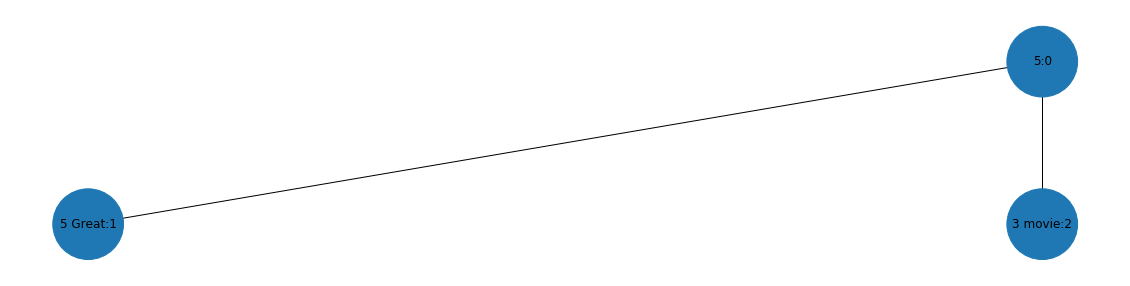

In [5]:
t = s.solve(example)
levels = preOrder(t)
draw(levels)

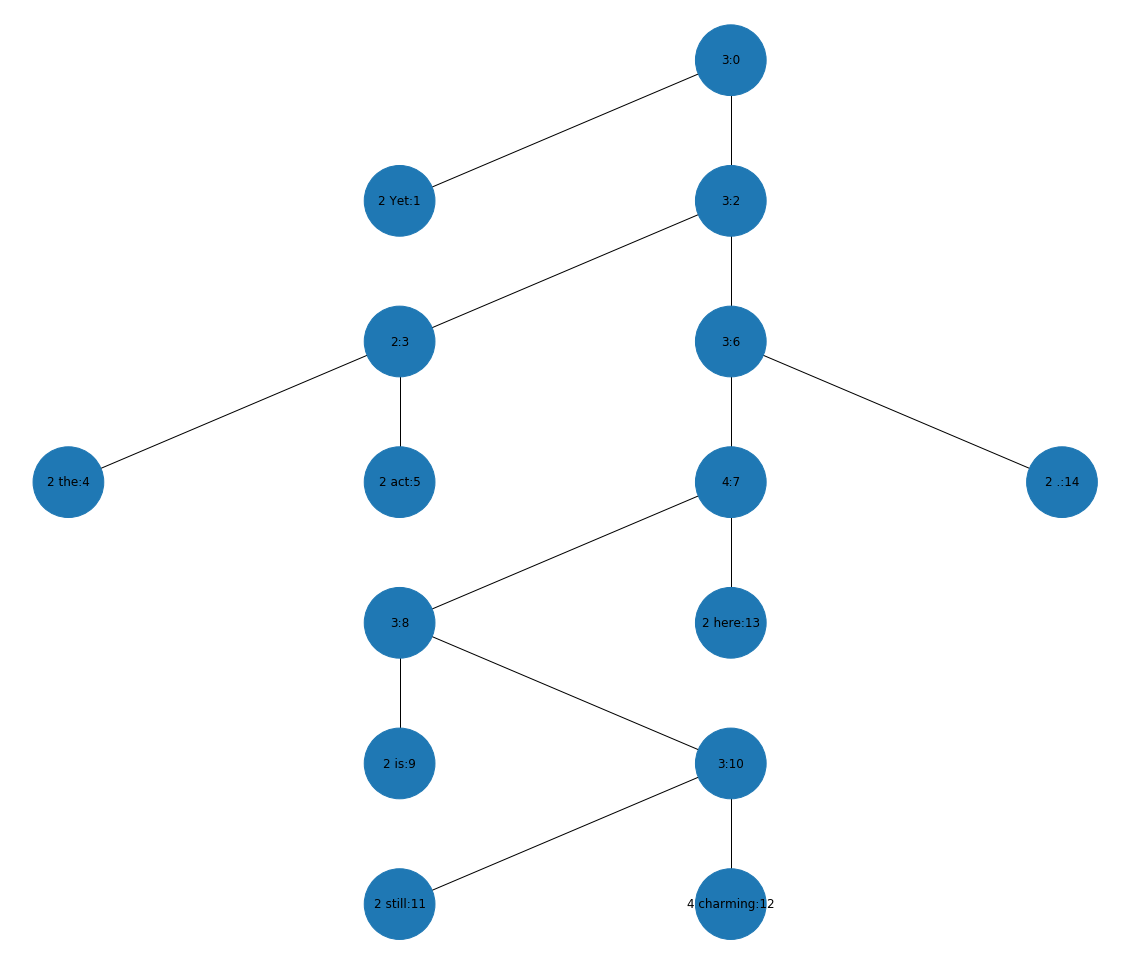

In [6]:
t = s.solve(ex2)
levels = preOrder(t)
draw(levels)

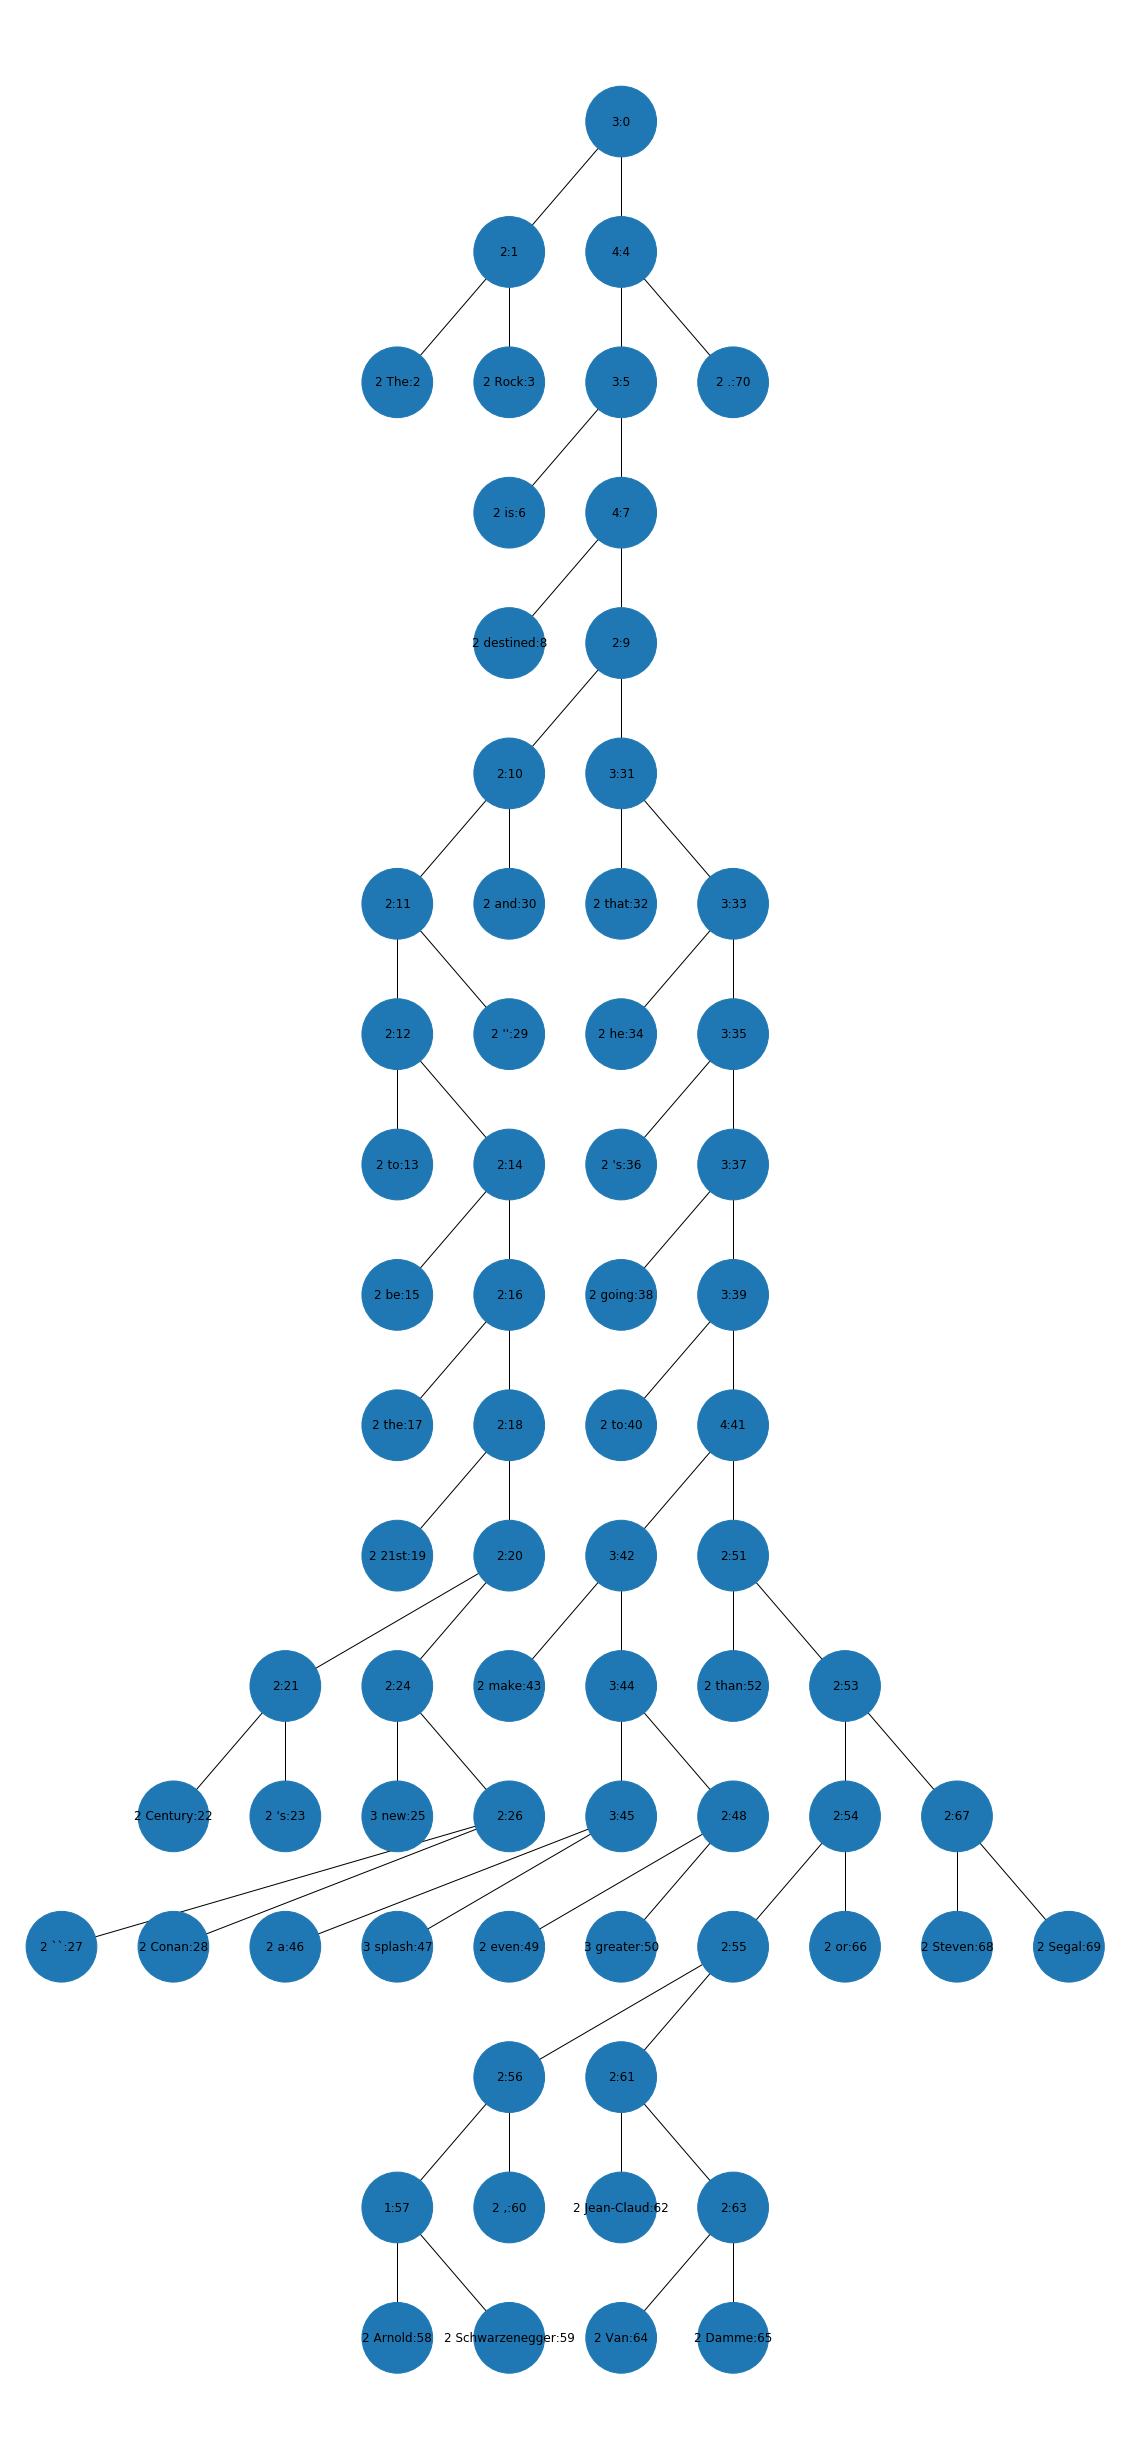

In [7]:
t = s.solve(pp.data[0])
levels = preOrder(t)
draw(levels)

#### Sentiment Analysis Data from Stanford University
- https://nlp.stanford.edu/sentiment/index.html
- https://www.nltk.org/book/ch08.html

In [8]:
print(len(pp.w2id_exp),len(pp.res[0]))
emb_layer = nn.Embedding(len(pp.w2id_exp),len(pp.res[0]))
emb_layer.load_state_dict({'weight':torch.Tensor(pp.embedMatrix)})

18646 50


<All keys matched successfully>

In [9]:
print(len(pp.trainTrees),len(pp.testTrees))

8544 2210


#### Tree Neural Network / Recursive Neural Network (Not Recurrent)
The node value is defined by its children by bottom-up propagation. 

Each child of the parent has a weight, if consider this as a binary tree, the propagation is defined as, 

$$\begin{align*}
h_1 &= f(W_{left}x_1+W_{right}x_2+b)\\
h_{root} &= f(W_{left}h_1+W_{right}x_3+b)
\end{align*}$$

where $x_n$ is a word embedding of the word. 

Each node then outputs the probability of the class, 

$$p(y|h)=\sigma(W_o h+b_o)$$

where $y$ is the class, and $\sigma$ is the softmax function.

In [22]:
print(pp.l2id)

{'3': 0, '2': 1, '4': 2, '1': 3, '0': 0}


In [29]:
class TNN(nn.Module):
    def __init__(self,pp):
        super().__init__()
        self.pp = pp
        self.emb = nn.Embedding(len(pp.w2id_exp),
                        len(pp.res[0]))
        self.emb.load_state_dict({'weight':\
                        torch.Tensor(pp.embedMatrix)})
        self.Wl = torch.randn(len(pp.res[0]),len(pp.res[0]))
        self.Wr= torch.randn(len(pp.res[0]),len(pp.res[0]))
        self.b = torch.randn(len(pp.res[0]))
        self.Wo = torch.randn(len(pp.res[0]),len(pp.l2id))
        self.bo = torch.randn(len(pp.res[0]))
    def postOrder(self,tree):
        def dfs(root):
            if root.word.strip() not in string.digits:
                word=root.word.strip().split(" ")[1].lower()
                v=torch.LongTensor([[self.pp.w2id_exp[word]]])
                return self.emb(v),0
            xl,lossl = dfs(root.left)
            xr,lossr = dfs(root.right)
            print(xl.shape,xr.shape)
            h = torch.matmul(xl,self.Wl)+self.b+\
                    torch.matmul(xr,self.Wr)
            print(h.shape)
            print("------")
            return h,0
        vec,loss = dfs(tree)
        print(vec,vec.shape,loss)
    def forward(self,x):
        self.postOrder(x)
        

In [30]:
model = TNN(pp)
model.forward(pp.trainTrees[0])

torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([1, 1, 50]) torch.Size([1, 1, 50])
torch.Size([1, 1, 50])
------
torch.Size([